# External depth regulation module: illustration

see overleaf for details

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

In [2]:
# targets
delta_p = -10  # regulation precision [dbar]
delta_m = 0.1 # surface mass excess [kg]

v_down = 0.2 # initial descent speed [m/s]
p = 200 # target depth 5 dbar]

In [3]:
# platform parameters
#a = 0.08
#h = 1.

# external module
#A = 0.15
#H = 0.1

# compressibility
gamma = 2e-6 # 1/dbar
# drag
c1 = 1

# water
rho_w_0 = 1030 # [kg/m^3]
delta_rho_w = 0.  # [kg/m^3]
gamma_w = 6e-6 # 1/dbar
drho_w_dp = 2*gamma_w*rho_w_0  # 1/dbar

g = 9.81 # gravity m/s^2

In [4]:
# beads
rho_b = 2*rho_w_0

# dead weights
rho_0 = 2*rho_w_0
rho_1 = 2*rho_w_0

In [5]:
T = 10 # days
rate_b = 1/60 # beads per minutes

N_b = int(T*24*60*rate_b)
print(f"{N_b} beads required for {T} days deployment and rate of release of {rate_b:.2e} bead/minute")

240 beads required for 10 days deployment and rate of release of 1.67e-02 bead/minute


Unkown variables: $m$, $m_b$, $m_1$

In [6]:
rho_w = lambda p: rho_w_0 + delta_rho_w + drho_w_dp*p

def solve_masses(a, h):

    V_f_s = np.pi*a**2/2 * h
    #+ np.pi*(A**2 - a**2)/2 * H
    V_f = lambda p: V_f_s*(1 - gamma*p)
    
    # state vector: m, m_1, m_b
    # should also allow the case where one of these parameters is fixed
    
    M_equ = np.array([1,
                      (rho_1-rho_w(p))/rho_1, 
                      N_b*(rho_b-rho_w(p))/rho_b,
                     ])
    b_equ = rho_w(p)*V_f(p)
    #
    M_reg = np.array([0, 
                      -delta_p*drho_w_dp/rho_1, 
                      -(rho_b-rho_w(p))/rho_b -N_b*delta_p*drho_w_dp/rho_b,
                     ])
    b_reg = delta_p * V_f(p) * (drho_w_dp - rho_w(p)*gamma)
    #
    M_sur = np.array([1, 0, N_b*(rho_b-rho_w(0))/rho_b])
    b_sur = rho_w(0)*V_f(0) - delta_m
    #
    M = np.vstack((M_equ, M_reg, M_sur))
    b = np.array([b_equ, b_reg, b_sur])
    m, m_1, m_b = np.linalg.solve(M, b)
    
    m_m0 = m + m_1 + N_b*m_b
    
    cd = c1 * np.abs(v_down) /2 /h
    rho_f = rho_w(0)/(1 - cd*v_down/g)
    #print(rho_f, rho_0, rho_w(p), m_m0)
    m_0 = m_m0 * rho_0/rho_w(p) * (rho_f - rho_w(p)) / (rho_0 - rho_f)
    
    return m, m_0, m_1, m_b

def solve_masses_xr(a, h):
    
    D = {}
    D["m"], D["m_0"], D["m_1"], D["m_b"] = \
            xr.apply_ufunc(solve_masses, 
                           a, h,
                           vectorize=True,
                           output_core_dims=[[]]*4,
                           output_dtypes=[float]*4,
                          )
    for k in D:
        _da = D[k].rename(k)
        #_da.attrs["unit"] = "kg"
        D[k] = _da
        
    ds = xr.merge([v for k,v in D.items()])
    
    ds["a"] = a
    ds["h"] = h
    
    ds["v_b"] = ds["m_b"]/rho_b
    ds["r_b"] = (3/4*ds.v_b)**(1/3)
    
    ds["m_0"] = ds.m_0.where(ds.m_0>0, other=0)
    
    ds["v_0"] = ds["m_0"]/rho_0
    ds["v_1"] = ds["m_1"]/rho_1
    
    return ds

In [7]:
#m, m_0, m_1, m_b = solve_masses(a, h)
#m, m_0, m_1, m_b

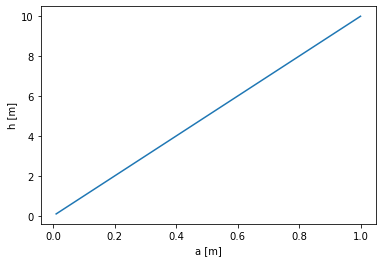

In [8]:
#ds = xr.Dataset(dict(a=("a", np.arange(1e-2, 1,1e-2))))
ds_in = xr.Dataset(dict(a=("a", np.logspace(-2, 0, 100))))
ds_in.a.attrs["units"] = "m"

ds_in["h"] = ds_in.a*10 # fixed aspect ratio
ds_in.h.attrs["units"] = "m"

ds_in.h.plot()

In [9]:
ds = solve_masses_xr(ds_in.a, ds_in.h)

ds["V_f_s"] = np.pi* ds.a**2/2 * ds.h
V_f = lambda p: ds.V_f_s*(1 - gamma*p)

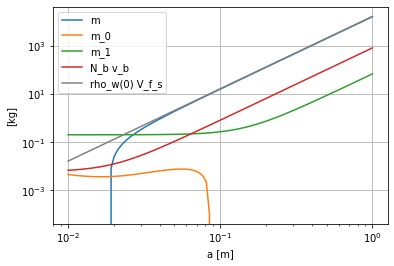

In [10]:
fig, ax = plt.subplots(1,1)
ds.m.plot(label="m")
ds.m_0.plot(label="m_0")
ds.m_1.plot(label="m_1")
(N_b*ds.m_b).plot(label="N_b v_b")

(rho_w(0)*ds.V_f_s).plot(color="0.5", label="rho_w(0) V_f_s")
#(rho_w(p)*ds.V_f_s).plot(color="0.5", ls="--", label="rho_w(p) V_f_s")

ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylabel("[kg]")
ax.legend()

The mass becomes negative when the system is so small it cannot lead to the prescribed final surface buoyancy.

The first dead weigth is not "necessary" any longer when the float is naturally dense enough to reach the desired speed.

### Rederive initial velocity

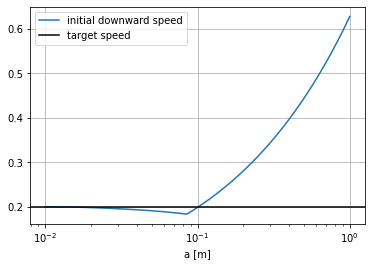

In [11]:
_m = (ds.m + ds.m_0 + ds.m_1 + N_b * ds.m_b)
_v = (V_f(0) + ds.v_0 + ds.v_1 + N_b*ds.v_b)
_rho_f = _m/_v

w2 = -2*ds.h/c1 * g*(rho_w(0)-_rho_f)/_rho_f

fig, ax = plt.subplots(1,1)
np.sqrt(w2).plot(label="initial downward speed")
ax.axhline(v_down, color="k", label="target speed")
ax.legend()
ax.grid()
ax.set_xscale("log")

### verifies equilibrium at depth

This without the first dead weight 

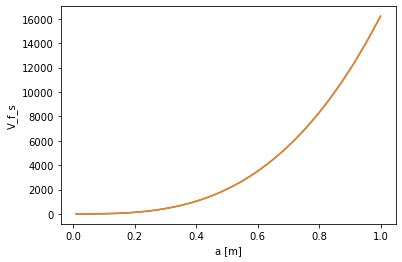

In [12]:
S0 = ds.m + (rho_1-rho_w(p))/rho_1 * ds.m_1 + N_b*(rho_b-rho_w(p))/rho_b * ds.m_b
S1 = rho_w(p)*V_f(p)

S0.plot()
S1.plot()

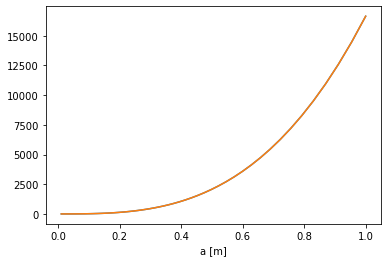

In [13]:
S0 = ds.m + ds.m_1 + N_b * ds.m_b
S1 = rho_w(p)* (V_f(p) + ds.m_1/rho_1 + N_b*ds.m_b/rho_b)

S0.plot()
S1.plot()

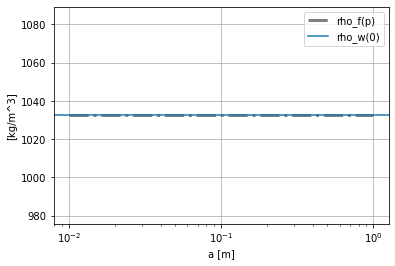

In [14]:
rho_f = (ds.m + ds.m_1 + N_b * ds.m_b)/(V_f(0) + ds.v_1 + N_b * ds.v_b)
rho_f_p = (ds.m + ds.m_1 + N_b * ds.m_b)/(V_f(p) + ds.v_1 + N_b * ds.v_b)

fig, ax = plt.subplots(1,1)

#rho_f.plot(color="k", label="rho_f(0)")
rho_f_p.plot(ls="-.", lw=3, color="0.5", label="rho_f(p)")
ax.axhline(rho_w(p), label="rho_w(0)")

ax.set_xscale("log")
#ax.set_yscale("log")
ax.grid()
ax.set_ylabel("[kg/m^3]")
ax.legend()

Text(0.5, 1.0, 'bead mass m_b')

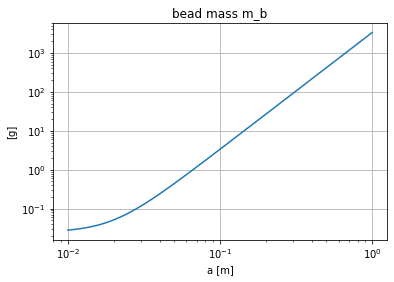

In [15]:
fig, ax = plt.subplots(1,1)
(ds.m_b*1e3).plot()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylabel("[g]")
ax.set_title("bead mass m_b")

Text(0.5, 1.0, 'bead radius')

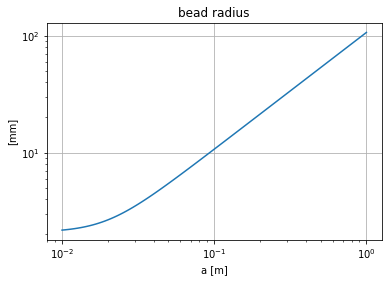

In [16]:
fig, ax = plt.subplots(1,1)
(ds.r_b*1e3).plot()
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid()
ax.set_ylabel("[mm]")
ax.set_title("bead radius")